In [892]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [893]:
with open('song_df_aggregate.pkl', 'rb') as f:
        song_df= pickle.load(f)  

In [323]:
song_df = song_df[song_df["firstrank"] > 10]

to_pop =["artist","title","isnew","rank","date","spotify_id","spotify_album_id","spotify_album_release_date",
         "spotify_album_release_date_precision","album_label","join","spotify_album_release_date_datetime",
         "datetime","first_date"]
[song_df.pop(i) for i in to_pop]


song_df.pop("bestrank")
song_df.pop("numberofappearances")
song_df = song_df.dropna()
top10 = song_df.pop("top10")

to_pop =["top50","top25","top75","top5"]
[song_df.pop(i) for i in to_pop]

to_pop =["label_appearance_count","label_category","label_appearance_count_group","release_month","release_year"]
[song_df.pop(i) for i in to_pop]

to_pop =["artist_has_award","spotify_disc_number","last_award_type","spotify_mode","num_artists","spotify_time_signature","album_type","spotify_explicit"]
[song_df.pop(i) for i in to_pop]

[0                       Lewis Capaldi
 1                         Post Malone
 2       Shawn Mendes & Camila Cabello
 3                               Lizzo
 4                        Selena Gomez
                     ...              
 8514                      Spice Girls
 8515                           Phajja
 8516               Sting & The Police
 8517                     Shania Twain
 8518                    Reba McEntire
 Name: artist, Length: 8519, dtype: object,
 0                           Someone You Loved
 1                                     Circles
 2                                    Senorita
 3                                 Truth Hurts
 4                         Lose You To Love Me
                         ...                  
 8514                       Spice Up Your Life
 8515               So Long (Well, Well, Well)
 8516           Roxanne `97 - Puff Daddy Remix
 8517    Don't Be Stupid (You Know I Love You)
 8518                                  What If
 Name: tit

In [344]:
le = preprocessing.LabelEncoder()
song_df['spotify_key'] = le.fit_transform(song_df['spotify_key'])
song_df['label_category_group'] = le.fit_transform(song_df['label_category_group'])
song_df['datetime_year'] = le.fit_transform(song_df['datetime_year'])
song_df['datetime_month'] = le.fit_transform(song_df['datetime_month'])

In [329]:
X_train, X_test, y_train, y_test = train_test_split(song_df, top10, test_size=0.2)

In [896]:
with open('test_set.pkl', 'rb') as f:
        X_test= pickle.load(f)  
with open('train_set.pkl', 'rb') as f:
        X_train= pickle.load(f)  
with open('ytest.pkl', 'rb') as f:
        y_test= pickle.load(f)  
with open('ytrain.pkl', 'rb') as f:
        y_train= pickle.load(f)  
for i in [X_train,X_test]:
    #i.pop("spotify_explicit")
    #i.pop("spotify_mode")
   #i.pop("num_artists")
    i.pop("artist_has_award")
    #i.pop("album_type")
    #i.pop("gold_count")
    #i.pop("spotify_time_signature")
    #i.pop("datetime_month")
    #i.pop("award_num")
    #i.pop("label_category_group")
    #i.pop("datetime_year")
    #i.pop("firstrank")
    #i.pop("num_songs_awards")
    #i.pop("platinum_count")

In [895]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [846]:
len(y_test[y_test["top10"]==1])

96

In [897]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.643692
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.711374
[3]	training's auc: 0.75586
[4]	training's auc: 0.769595
[5]	training's auc: 0.780106
[6]	training's auc: 0.789227
[7]	training's auc: 0.800747
[8]	training's auc: 0.805211
[9]	training's auc: 0.806446
[10]	training's auc: 0.811684
[11]	training's auc: 0.819147
[12]	training's auc: 0.820416
[13]	training's auc: 0.8233
[14]	training's auc: 0.825859
[15]	training's auc: 0.832436
[16]	training's auc: 0.83428
[17]	training's auc: 0.837645
[18]	training's auc: 0.837637
[19]	training's auc: 0.838567
[20]	training's auc: 0.840964
[21]	training's auc: 0.845303
[22]	training's auc: 0.846865
[23]	training's auc: 0.84915
[24]	training's auc: 0.851562
[25]	training's auc: 0.854607
[26]	training's auc: 0.857947
[27]	training's auc: 0.861008
[28]	training's auc: 0.861555
[29]	training's auc: 0.861983
[30]	training's auc: 0.863747
[31]	training's auc: 0.865241
[32]	training's auc: 0

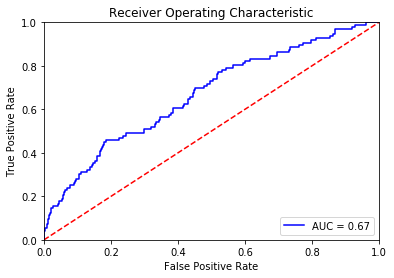

In [898]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

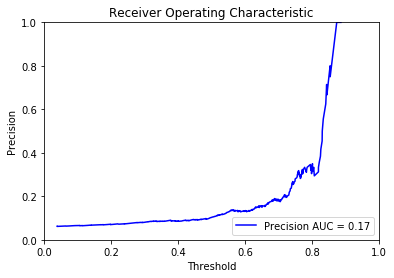

In [899]:
from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predictions)
# calculate precision-recall AUC
precision_auc = metrics.auc(recall, precision)

plt.title('Receiver Operating Characteristic')
plt.plot(thresholds, precision[:len(precision)-1], 'b', label = 'Precision AUC = %0.2f' % precision_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.show()

In [900]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.85 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[1505,    1],
       [  92,    4]])

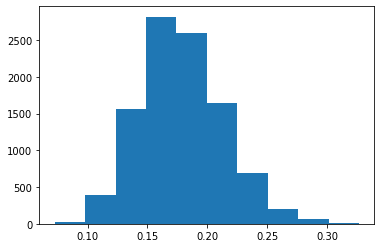

95.0 confidence interval 11.7% and 25.3%


In [845]:
from sklearn.utils import resample
df = X_test
df["top10"] = y_test.values
stats = list()
for i in range(10000):
    boot = resample(df, replace=True, n_samples=1000)
    boot_y = boot.pop("top10")
    boot_pred = model.predict(boot)
    predictions_matrix = [1 if pred > 0.8 else 0 for pred in boot_pred]
    precision = (confusion_matrix(boot_y,predictions_matrix)[1][1]) / (confusion_matrix(boot_y,predictions_matrix)[0][1] + confusion_matrix(boot_y,predictions_matrix)[0][1]) 
    stats.append(precision)
    
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [795]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

17 spotify_explicit
187 spotify_duration_ms
75 spotify_track_number
146 spotify_danceability
164 spotify_energy
145 spotify_loudness
28 spotify_mode
182 spotify_speechiness
174 spotify_acousticness
90 spotify_instrumentalness
121 spotify_liveness
167 spotify_valence
161 spotify_tempo
10 spotify_time_signature
31 num_artists
82 award_num
81 gold_count
66 platinum_count
3 artist_has_award
38 num_songs_awards
148 firstrank
64 label_category_group
29 album_type
141 datetime_year
50 datetime_month


In [902]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [810]:
'''X_train["top10"] = y_train
X_train = X_train.sample(frac=1)
top_df = X_train.loc[X_train['top10'] == 1]
non_top_df = X_train.loc[X_train['top10'] == 0][:600]
X_train = pd.concat([top_df, non_top_df])
y_train = X_train.pop("top10")'''

'X_train["top10"] = y_train\nX_train = X_train.sample(frac=1)\ntop_df = X_train.loc[X_train[\'top10\'] == 1]\nnon_top_df = X_train.loc[X_train[\'top10\'] == 0][:600]\nX_train = pd.concat([top_df, non_top_df])\ny_train = X_train.pop("top10")'

In [901]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [854]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.59


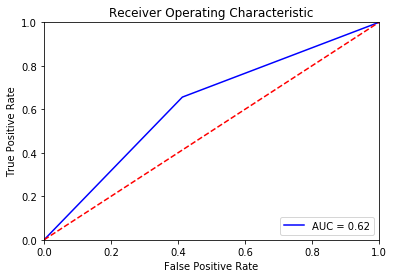

In [903]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("Logisticregression")
plt.show()


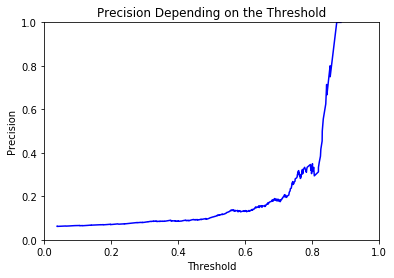

In [904]:
from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predictions)
# calculate precision-recall AUC
precision_auc = metrics.auc(recall, precision)

plt.title('Precision Depending on the Threshold')
plt.plot(thresholds, precision[:len(precision)-1], 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.savefig("PrecisionLogistic")
plt.show()

In [906]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.7 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[1424,   82],
       [  78,   18]])

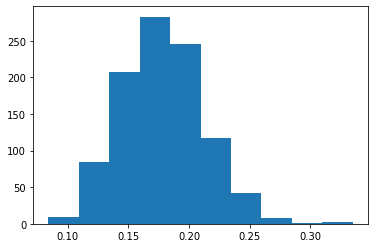

95.0 confidence interval 11.5% and 24.7%


In [861]:
from sklearn.utils import resample
df = X_test
df["top10"] = y_test.values
stats = list()
for i in range(1000):
    boot = resample(df, replace=True, n_samples=10000)
    boot_y = boot.pop("top10")
    boot_pred = model.predict(boot)
    predictions_matrix = [1 if pred > 0.8 else 0 for pred in boot_pred]
    precision = (confusion_matrix(boot_y,predictions_matrix)[1][1]) / (confusion_matrix(boot_y,predictions_matrix)[0][1] + confusion_matrix(boot_y,predictions_matrix)[0][1]) 
    stats.append(precision)
    
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [862]:
logreg.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'